In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")


# Load Dataset into DataFrame

In [2]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,...,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,...,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,...,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43954,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
43955,57.0,2.0,867.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0
43956,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
43957,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,...,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0


# Data Preparation

## Standardization of numeric variables

In [3]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Turn 0 (not rated) into binary variables 

The satisfaction level of each feature should range from 1 to 5. 

If the rating is 0, that means the customer did not rate for this feature.

We convert such value into binary column to indicate if certain features was rated by the customer or not.


In [4]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [5]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

In [31]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

<span style='color:red'> <b> We should consider these rows as missing values. </b> </span>

Two ways to handle it:
1. add dummy col
2. impute


In [6]:
# baggage headling do not have any 0 values
dummy_cols = {'Inflight_wifi_service_0': ['Inflight_wifi_service'], 
              'Departure/Arrival_time_convenient_0': ['Departure/Arrival_time_convenient'],
              'Ease_of_Online_booking_0': ['Ease_of_Online_booking'],
              'Online_boarding_0': ['Online_boarding'],
              'Leg_room_service_0': ['Leg_room_service']}
              
# Loop through each set of columns and create the new dummy variable
for dummy_col, cols_to_check in dummy_cols.items():
    data[dummy_col] = (data[cols_to_check] == 0).all(axis=1).astype(int)

# Splitting the Dataset

Identify features and target

In [7]:
X = data.drop(columns=['satisfaction'])
y = data['satisfaction']

## Train Test Split

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(35167, 8792)

## Test Validation Split

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4396, 4396)

In [10]:
data.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel', 'Inflight_wifi_service_0',
       'Departure/Arrival_time_convenient_0', 'Ease_of_Online_booking_0',
       'Online_boarding_0', 'Leg_room_service_0'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [11]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [12]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [13]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [14]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

# Verify Class Balance

In [15]:
data['satisfaction'].value_counts()

1.0    23995
0.0    19964
Name: satisfaction, dtype: int64

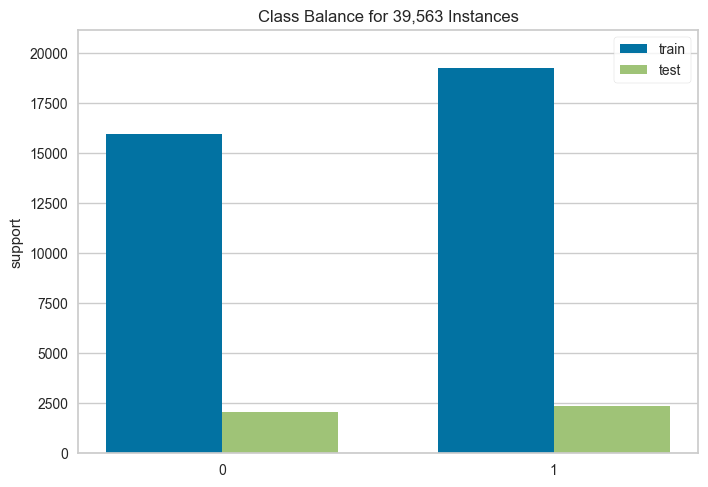

<AxesSubplot: title={'center': 'Class Balance for 39,563 Instances'}, ylabel='support'>

In [16]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Modelling

Baseline Model - DummyClassifier ✔

==========================

Feature Selection 
- LASSO (prefered)
- RFE

=====================

Regression:
- Logistics Regression

Neighbors:
- KNN

Naive Bayes:
- Gaussian

Ensemble Methods:
- Decision Tree
- Random Forest

===========================
- AdsBoost
- CatBoost
- Gradient Boosting
- Stacked generalization

Neural Nets:
- SVM
- Multi Layer Perception
- AdaNet

## Baseline Model - DummyClassifier

In [17]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.5366



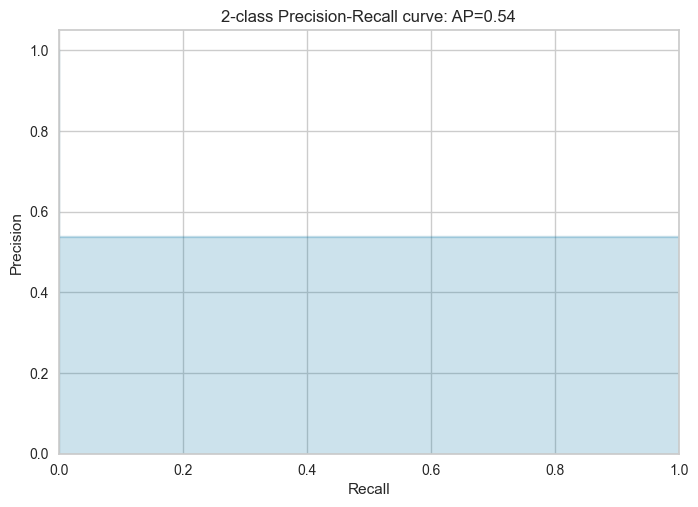

roc auc score: 0.5



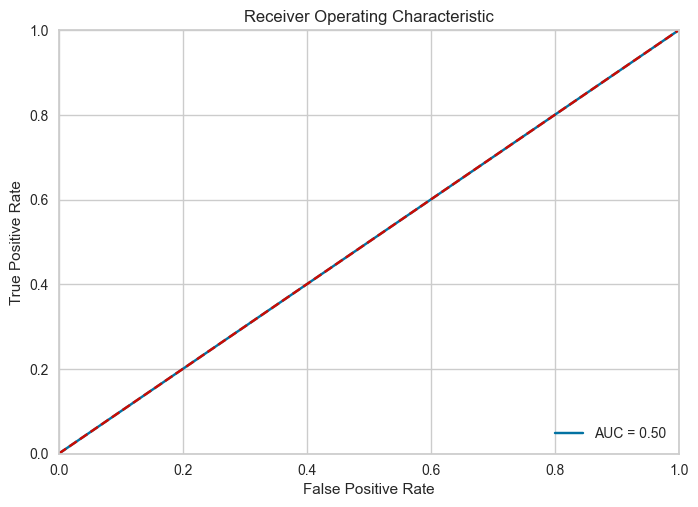

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2037
         1.0       0.54      1.00      0.70      2359

    accuracy                           0.54      4396
   macro avg       0.27      0.50      0.35      4396
weighted avg       0.29      0.54      0.37      4396


Confusion Matrix: 
 [[   0 2037]
 [   0 2359]]

End of validation Result



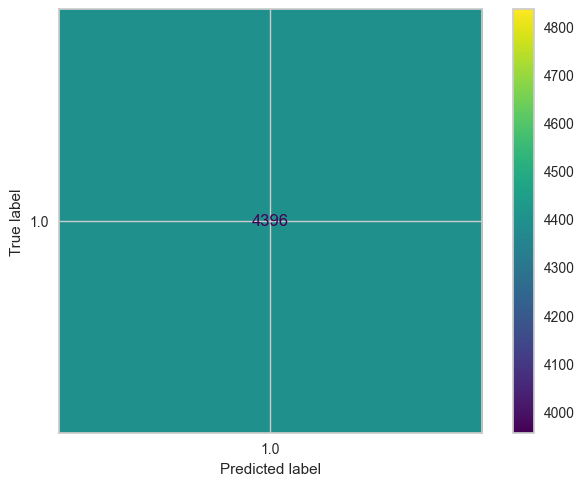

In [18]:
clf_score(dummy, X_train, y_train, X_val, y_val, train=False)

In [19]:
# Add result to model_comparison dataframe
model_name = 'DummyClassifier'
y_pred = dummy.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision  recall  f1-score support
DummyClassifier   0.536624     1.0  0.698446    2359


## Feature Selection

### 1. LASSO

In [20]:
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_train, y_train)

In [21]:
model_lasso.coef_

array([ 0.0028595 , -0.13652583,  0.01307159,  0.        , -0.00768869,
       -0.        ,  0.00308803, -0.        ,  0.09802086,  0.03320215,
        0.02738485,  0.04222833,  0.03874611,  0.02498011,  0.03505258,
        0.01838407,  0.0308277 , -0.00324291,  0.        ,  0.08463068,
        0.21443312,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ])

In [22]:
pd.DataFrame(list(zip(X_train.columns,model_lasso.coef_)), columns = ['predictor','coefficient'])

,predictor,coefficient
0,Age,0.002859
1,Class,-0.136526
2,Flight_Distance,0.013072
3,Inflight_wifi_service,0.000000
4,Departure/Arrival_time_convenient,-0.007689
5,Ease_of_Online_booking,-0.000000
6,Gate_location,0.003088
7,Food_and_drink,-0.000000
8,Online_boarding,0.098021
9,Seat_comfort,0.033202


### 2. RFE

In [23]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=3) 
model_rfe = rfe.fit(X_train,y_train)

In [24]:
model_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False])

In [32]:
pd.DataFrame(list(zip(X_train.columns,model_rfe.ranking_)), 
             columns = ['predictor','ranking']).sort_values(by='ranking')

,predictor,ranking
19,Customer_Type_Loyal Customer,1
20,Type_of_Travel_Business travel,1
21,Inflight_wifi_service_0,1
13,Baggage_handling,2
8,Online_boarding,3
9,Seat_comfort,4
11,On-board_service,5
15,Inflight_service,6
16,Cleanliness,7
14,Checkin_service,8


## Logistic Regression

In [26]:
# Add result to model_comparison dataframe
model_name = 'LogisticRegression'
y_pred = #???

add_result(model_name, y_val, y_pred)

SyntaxError: invalid syntax (1136493529.py, line 3)

## K-Nearest Neighbor

In [ ]:
# Add result to model_comparison dataframe
model_name = 'KNN'
y_pred = #???

add_result(model_name, y_val, y_pred)

## Naive Bayesian

## Decision Tree

## Random Forest

## Adaboost

In [ ]:
# Add result to model_comparison dataframe
model_name = 'AdaBoost'
y_pred = #???

add_result(model_name, y_val, y_pred)

## LightGBM

## XGBoost

In [ ]:
# Add result to model_comparison dataframe
model_name = 'XGBoost'
y_pred = #???

add_result(model_name, y_val, y_pred)

## Stacked Generalization

## Support-Vector Machines